# Zynq PS with CRC

Cyclic Redundancy Code/Check is a widely used to detect data corruption during data transmission. Since data transmission is the basic building block of modern systems, CRCs algorithms are candidates suitable for hardware Acceleration.

More information about 
This Notebook demonstrates the working of a 32bit CRC Accelerator integrated with the Processing System(PS) present in the Zynq 7000 SoC.
The CRC IP is a Verilog Module present the Programmable Logic(PL) region of the SoC.

__CRC is a Error Detection Code, meaning it will detect errors but not correct them. More sophisticated encoding methods like Hamming Codes and Reed Solomon Codes can be used for Error Detection and Corruption.__

More information about this project can be found in our [Wiki page](http://venividiwiki.ee.virginia.edu/mediawiki/index.php/Parameterized_CRC_Accelerator) [Requires the user to be connected to the UVA network].

A wonderful [tutorial](http://www.ross.net/crc/download/crc_v3.txt) on CRC. 

## Block Diagram

![CRC System](./crc_system.png)

The Accelerator is intergrated with Zynq processing system thorugh AXI lite Interface.

### Assumed block diagram for demonstration
![CRC Demonstration Block Diagram](./crc_demo_block.png)

Each packet of data is 32bit or 16bit wide. If the i^th^ packet transmitted contains image data, the i+1^th^ packet contains the CRC of the data.

The noise is introduced into the received data in the channel by a python function.

### Importing the required packages

In [1]:
# Xilinx PyPi Package import
from pynq import Overlay
from pynq import MMIO

# Non-Xilinx Python package imports
import os
import numpy as np
import binascii
from PIL import Image
import cv2
import random as random

import pandas as pd
from IPython.display import display

import crcmod.predefined
from codecs import decode as decode

import time

### Initialize other functions

We wrote some functions to carry out data(format) conversion and to inject randomized noise into data.
We also have a wrapper function around software CRC library instantiation which will help with performance comparisons.

#### Function to load an image and convert it into a list of 32bit hexadecimal values

In [2]:
"""
    Function to return the list of hex values when given a file name
    input: string = Path to the file
    returns: list = the file sliced into 32bit hex elements
"""
def return_hex_list(file):
    
    # read the file
    # the file size is 4kb for the examples we use
    with open(file, 'rb') as f:
        content = f.read()
    
    # print the length of the bytestream
    print("length of the bytestream: ", len(content))
    
    # the list will contain 4bytes per element in hex format
    # converting the image data from bytes to hex will lead to a size increase
    temp_val = content.hex()
    len_tv = len(temp_val)
    
    # print the length of the bytestream
    print("length of the hex stream of the image: ", len_tv)    
    
    # we find the closest power of two to pad the stream
    if (len_tv > 1):
        for i in range(1, len_tv):
            if (2**i >= len_tv):
                size = 2**i
                break
    
    print("length of the generated hex stream: ", size)
    
    st = temp_val.ljust(size,'0')
    hex_list = []
    
    for i in range(0, len(st), 8):
        hex_list.append(((int(st[i]  , 16) << 28) | \
                         (int(st[i+1], 16) << 24) | \
                         (int(st[i+2], 16) << 20) | \
                         (int(st[i+3], 16) << 16) | \
                         (int(st[i+4], 16) << 12) | \
                         (int(st[i+5], 16) <<  8) | \
                         (int(st[i+6], 16) <<  4) | \
                         (int(st[i+7], 16))))   
    
    # print the number of 32bit elements in the list
    print("number of 32bit elements in the list: ", len(hex_list))
    print("size of the image", 4*(len(hex_list)), "Bytes")
    
    return hex_list

### Function to load an image and convert it into a list of 16bit hexadecimal values

In [3]:
"""
    Function to return the list of hex values when given a file name
    input: string = Path to the file
    returns: list = the file sliced into 32bit hex elements
"""
def return_hex16_list(file):
    
    # read the file
    # the file size is 4kb for the examples we use
    with open(file, 'rb') as f:
        content = f.read()
    
    # print the length of the bytestream
    print("length of the bytestream: ", len(content))
    
    # the list will contain 4bytes per element in hex format
    # converting the image data from bytes to hex will lead to a size increase
    temp_val = content.hex()
    len_tv = len(temp_val)
    
    # print the length of the bytestream
    print("length of the hex stream of the image: ", len_tv)    
    
    # we find the closest power of two to pad the stream
    if (len_tv > 1):
        for i in range(1, len_tv):
            if (2**i >= len_tv):
                size = 2**i
                break
    
    print("length of the generated hex stream: ", size)
    
    st = temp_val.ljust(size,'0')
    hex_list = []
    
    for i in range(0, len(st), 4):
        hex_list.append(((int(st[i]  , 16) << 12) | \
                         (int(st[i+1], 16) <<  8) | \
                         (int(st[i+2], 16) <<  4) | \
                         (int(st[i+3], 16))))  
    
    # print the number of 32bit elements in the list
    print("number of 16bit elements in the list: ", len(hex_list))
    print("size of the image", 2*(len(hex_list)), "Bytes")
    
    return hex_list

#### Inject random noise into a hex list.

In [4]:
# noise can affect both data and crc value
def noisy(x, threshold):
    for i in range (len(x)):
        if random.randint(0, 1000) > threshold:
            x[i] = x[i] ^ random.randint(0, 2^32) & 0xFFFFFFFF
        else:
            x[i] = x[i]
    return x

#### CRC computation with software library

In [5]:
def soft_crc(value):
    # convert the input stream into bytes
    value = value.replace("0x", "")
    value = value.rjust(8, '0')
    value = decode(value, 'hex_codec')
    
    crc32_func = crcmod.predefined.mkCrcFun('crc-32-mpeg')
    res = crc32_func(value)
    return res

In [6]:
def soft_crc_16(value):
    # convert the input stream into bytes
    value = value.replace("0x", "")
    value = value.rjust(4, '0')
    value = decode(value, 'hex_codec')
    
    crc16_func = crcmod.predefined.mkCrcFun('crc-16-buypass')
    res = crc16_func(value)
    return res

#### Convert a Hex list into an image

In [7]:
def hex_to_img(hex_list, filename):
    hex_img = []

    for i in range(0, len(hex_list)):
        hex_img.append(hex(hex_list[i]).replace("0x", '').rjust(8, "0"))
    
    hex_img = decode(''.join(hex_img), 'hex_codec')
    with open(filename, 'wb') as f:
        f.write(hex_img)
    return(filename)

#### Convert a 16bit Hex list into an image

In [8]:
def hex16_to_img(hex_list, filename):
    hex_img = []

    for i in range(0, len(hex_list)):
        hex_img.append(hex(hex_list[i]).replace("0x", '').rjust(4, "0"))
    
    hex_img = decode(''.join(hex_img), 'hex_codec')
    with open(filename, 'wb') as f:
        f.write(hex_img)
    return(filename)

### Creation of the Overlay with the Bitstream

In [9]:
ol = Overlay("crc.bit")

### Setting up the Memory Regions

The CRC IP and the BRAM present in the PL are interfaced as Memory Mapped IPs interacting with the PS through AXI4-Lite.

In [10]:
# Base address of the CRC IP
base_address_crc = 0x43C00000
# Base address of the BRAM
base_address_mem = 0x40000000

# Size of the Memory(In Bytes) mapped to the IP memory/registers in the PS address space
# CRC has 4 registers of 32bit width
crc_regmem_size = 128

# The BRAM size is 8kB
bram_mem_size = 8192

### Creating MMIO objects to interact with the Memory Mapped IPs

In [11]:
# Object to interact with the CRC IP
mmio_crc = MMIO(base_address_crc, crc_regmem_size)
# Object to interact with the BRAM IP
mmio_bram = MMIO(base_address_mem, bram_mem_size)

#### Set up address offsets for the MMIO

In [12]:
# we use offsets to read from the MMIO AXI CRC IP
crc_data_offset = 0x0
crc_init_offset = 0x4
crc_sel_offset = 0x8
crc_result_offset = 0xc

# we use offsets to read from the MMIO AXI BRAM
bram_address_offset = 0x0

# default select value for 32bit CRC
crc_sel_32 = 0xf
# any value other than 0xf will result in crc16 being returned
crc_sel_16 = 0x0

#### Clear the BRAM and write zeros into it.

In [13]:
for i in range(0, int(bram_mem_size/4)):
    # Since memory in AXI is byte Addresses, and the access granularity is 4bytes
    # the offset should be a multiple of 4
    mmio_bram.write(bram_address_offset+(i*4), 0)

#### Clear the CRC input registers and write zeros into it.

In [14]:
mmio_crc.write(crc_data_offset,0)
mmio_crc.write(crc_init_offset, 0)
mmio_crc.write(crc_sel_offset, 0)

### Read an image and Store it in the BRAM

The size of the BRAM is 8kB. The image is chosen to be smaller than that.

![Test Image](.\test_image.jpg)

In [15]:
# path to the file
file = "./test_image.jpg"
# read the file and convert it into a list of hexadecimal values
# img_hex = [0xbabecafe, 0xdeadbeef, ..., 0xdeadcafe]
img_hex = return_hex_list(file)

length of the bytestream:  3549
length of the hex stream of the image:  7098
length of the generated hex stream:  8192
number of 32bit elements in the list:  1024
size of the image 4096 Bytes


Write into the BRAM

In [16]:
for i in range(0, len(img_hex)):
    # Since memory in AXI is byte Addresses, and the access granularity is 4bytes
    # the offset should be a multiple of 4
    mmio_bram.write(bram_address_offset+(i*4), img_hex[i])

print("written data into the 8kB BRAM")

written data into the 8kB BRAM


## Demonstration of CRC Accelerator detecting error occuring during transmission

The Image stored in the BRAM will be transmitted to the receiver along with the CRC of the image.

### CRC MPEG2 (IEEE 802.3) Specific Setup
The initial value is fixed to 0xFFFFFFFF for IEEE 802.3

In [17]:
crc_initial_data = 0xffffffff

The CRC IP will read directly from the BRAM and perform the CRC Calculation.
The output from the CRC, and the image are stored in a buffer

_Ideally this will then get transmitted to the world._

But for demonstration, we **do not** send the data out but write it into a _output buffer_.

We then copy the data from the _output buffer_ to the _input buffer_ and perform our check on it.
This copy operation is expected to mimic a data transfer.

The Jupyter notebook functions like a controller interfacing between the CRC IP and the BRAM.

### Transmitter End

In [18]:
# The output buffer contains the image and the associated CRC at 4byte granularity
# output_buffer = [img[0], crc32(img[0]), img[1], crc32(img[1]), ......]
output_buffer = []

for i in range(len(img_hex)):
    output_buffer.append(mmio_bram.read(i*4))
    mmio_crc.write(crc_data_offset, output_buffer[i*2])
    mmio_crc.write(crc_init_offset, crc_initial_data)
    mmio_crc.write(crc_sel_offset, crc_sel_32)
    output_buffer.append(mmio_crc.read(crc_result_offset))

### Receiver End

The receiver will receive 32 bit packets.
The order of packets is

Packet 1 - Image[0:31]

Packet 2 - CRC of Packet[1]

...

Packet n-1 - Image[n-31:n]

Packet n - CRC of Packet[n]

In [19]:
# Mimic the transmission
input_buffer = output_buffer

# The input_buffer will feed two separate buffers, CRC buffer and data buffer
data_input_buffer = []
crc_input_buffer = []

# distribute the data to the two dedicated buffers
for i in range(0, len(input_buffer), 2):
    data_input_buffer.append(input_buffer[i])
    crc_input_buffer.append(input_buffer[i+1])

calculated_crc_buffer = []
# we use ofsets to read from the MMIO AXI CRC IP
crc_address_offset = 0x0

for i in range(len(data_input_buffer)):
    mmio_crc.write(crc_data_offset, data_input_buffer[i])
    mmio_crc.write(crc_init_offset, crc_initial_data)
    mmio_crc.write(crc_sel_offset, crc_sel_32)
    calculated_crc_buffer.append(mmio_crc.read(crc_result_offset))

#### Compare the Calculated CRC and the Received CRC

In [20]:
print("MATCH") if (crc_input_buffer == calculated_crc_buffer) else print("RESEND DATA")

MATCH


In the real world, if the comparison fails due to a mismatch the data is transmitted again.

Convert the received Hex into Image and display it

In [21]:
hex_to_img(data_input_buffer, './without_noise.png')

'./without_noise.png'

### The transmitted Image is

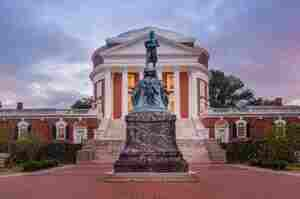

In [22]:
test_im = Image.open('./without_noise.png')
display(test_im)

In [23]:
count = 0
for i in range(len(crc_input_buffer)):
    if (crc_input_buffer[i] != calculated_crc_buffer[i]):
        print('CRC mismatch for Data Element', i)
        count =  count + 1

print('Number of Mismatches', count)

Number of Mismatches 0


### Validate CRC

In [24]:
crc_output_buffer = []
software_crc_buffer = []

for i in range(1, len(output_buffer), 2):
    crc_output_buffer.append(hex(output_buffer[i]))

for i in range(0, len(output_buffer), 2):
    software_crc_buffer.append(hex(soft_crc(hex(output_buffer[i]))))

In [25]:
print("SW and HW CRC Match") if (crc_output_buffer == software_crc_buffer) else print("SW and HW CRC Mismatch")

SW and HW CRC Match


In [26]:
print('Size of the image in 32b granularity:', len(img_hex))
print('Size of the output_buffer:', len(output_buffer))


temp_img_hex = []
temp_output_buffer = []

for i in range(0, 10):
    temp_img_hex.append(hex(img_hex[i]))
for i in range(0, 20, 2):
    temp_output_buffer.append(hex(output_buffer[i+1]))

software_crc = []

# CRC results from software library
for i in range(0, 10):
    software_crc.append(hex(soft_crc(temp_img_hex[i])))
    
dict = {'CRC from Accelerator'           : temp_output_buffer,
        'CRC from software library'      : software_crc,
        'Image data in 32b Hex'          : temp_img_hex,
        'element'                        : [i for i in range(1, 11)]
        }

df = pd.DataFrame(dict)
df = df.set_index('element', drop=True)
df = df[['Image data in 32b Hex', 'CRC from Accelerator', 'CRC from software library']]
display(df)

Size of the image in 32b granularity: 1024
Size of the output_buffer: 2048


,Image data in 32b Hex,CRC from Accelerator,CRC from software library
element,,,
1,0xffd8ffe0,0x4a40b1b8,0x4a40b1b8
2,0x104a46,0x9f7299df,0x9f7299df
3,0x49460001,0x45a998f6,0x45a998f6
4,0x1000001,0x1fa85a7b,0x1fa85a7b
5,0x10000,0xc6dc71fc,0xc6dc71fc
6,0xfffe003b,0x1e96e0b,0x1e96e0b
7,0x43524541,0xf84cae07,0xf84cae07
8,0x544f523a,0xea4efcf3,0xea4efcf3
9,0x2067642d,0xe8f726cf,0xe8f726cf


## Let us Make it Noisy

In [27]:
# Data to input buffer witnesses noise and gets corrupted
input_buffer = noisy(output_buffer, 998)

In [28]:
# The input_buffer will feed two separate buffers, CRC buffer and data buffer
data_input_buffer = []
crc_input_buffer = []

# we use ofsets to read from the MMIO AXI CRC IP
crc_address_offset = 0x0

# distribute the data to the two dedicated buffers
for i in range(0, len(input_buffer), 2):
    data_input_buffer.append(input_buffer[i])
    crc_input_buffer.append(input_buffer[i+1])

calculated_crc_buffer = []

for i in range(len(data_input_buffer)):
    mmio_crc.write(crc_data_offset, data_input_buffer[i])
    mmio_crc.write(crc_init_offset, crc_initial_data)
    mmio_crc.write(crc_sel_offset, crc_sel_32)
    calculated_crc_buffer.append(mmio_crc.read(crc_result_offset))
    
    """
        IF we do not want to waste power computing after the first mismatch
        we can break from the loop.
    """
    #if calculated_crc_buffer[i] != crc_input_buffer[i]:
    #    break

#### Compare the Calculated CRC and the Received CRC

In [29]:
print("MATCH") if (crc_input_buffer == calculated_crc_buffer) else print("RESEND DATA")

RESEND DATA


Ideally, we stop here and request the data to be resent.

Since this is a simulation, we can look at the image which we received and  also find the particular elements which mismatched.

Convert Hex to Image

In [30]:
hex_to_img(data_input_buffer, './with_noise.png')

'./with_noise.png'

### The transmitted Image is

The image is _usually_ not printed due to data corruption. But if it is printed, the data corruption is observable.

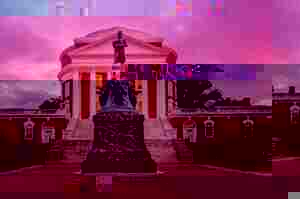

In [31]:
test_im = Image.open('./with_noise.png')
try:
    display(test_im) 
except Error as e:
    print(e.Error)

Since we are using python lists to simulate buffers, we can also identify which particular element did not match.

In [32]:
count = 0
for i in range(len(crc_input_buffer)):
    if (crc_input_buffer[i] != calculated_crc_buffer[i]):
        print('CRC mismatch for Data Element', i)
        count =  count + 1

print('Number of Mismatches', count)

CRC mismatch for Data Element 100
CRC mismatch for Data Element 206
CRC mismatch for Data Element 264
CRC mismatch for Data Element 756
CRC mismatch for Data Element 759
CRC mismatch for Data Element 855
Number of Mismatches 6


It should be noted that the Error can occur in both the __Data__ as well as the transmitted __CRC__. Either way, we resend the data again.

## Demonstrate Performance Over Software Libraries

We use the [CRCMod Package](https://pypi.org/project/crcmod/) [available on PyPi] for our software comparisons.

The packae supports multiple CRC standards. The supported versions can be found [here](https://crcmod.sourceforge.net/crcmod.predefined.html)

We start fresh. We read the image, convert it into hex and then store it in the BRAM.

In [33]:
# Initial Setup to make sure the BRAM is clean and we are not dealing with wrong data.
# we use offsets to read from the MMIO AXI CRC IP
crc_data_offset = 0x0
crc_init_offset = 0x4
crc_sel_offset = 0x8
crc_result_offset = 0xc

# we use offsets to read from the MMIO AXI BRAM
bram_address_offset = 0x0

# Clean the BRAM
for i in range(0, int(bram_mem_size/4)):
    # Since memory in AXI is byte Addresses, and the access granularity is 4bytes
    # the offset should be a multiple of 4
    mmio_bram.write(bram_address_offset+(i*4), 0)

# Clean the CRC Registers
mmio_crc.write(crc_data_offset,0)
mmio_crc.write(crc_init_offset, 0)
mmio_crc.write(crc_sel_offset, 0)

# read the image and write it into the BRAM

# path to the file
file = "./test_image.jpg"
# read the file and convert it into a list of hexadecimal values
# img_hex = [0xbabecafe, 0xdeadbeef, ..., 0xdeadcafe]
img_hex = return_hex_list(file)

for i in range(0, len(img_hex)):
    # Since memory in AXI is byte Addresses, and the access granularity is 4bytes
    # the offset should be a multiple of 4
    mmio_bram.write(bram_address_offset+(i*4), img_hex[i])

print("written data into the 8kB BRAM")

length of the bytestream:  3549
length of the hex stream of the image:  7098
length of the generated hex stream:  8192
number of 32bit elements in the list:  1024
size of the image 4096 Bytes
written data into the 8kB BRAM


### Hardware CRC Performance Metrics

We will compute the CRC of the same 4kB image 10 times and obtain the average time taken for the computation.

In [34]:
# function to compute the CRC and store it in a list.

def hardware_crc():
    """
    This function is a wrapper around the CRC computation performed on the accelerator.
    The data is read from the BRAM and the computed CRC is stored in a list (simulating a buffer)
    """
    # The ith element of the output buffer contains the CRC of ith data element stored in the BRAM
    # Data is addressed in the DRAM at 4byte granularity
    # output_buffer = [crc32(bram[0]), crc32(bram[1]), ......]

    output_buffer = []

    for i in range(len(img_hex)):
        # output_buffer.append(mmio_bram.read(i*4))
        mmio_crc.write(crc_data_offset, mmio_bram.read(i*4))
        mmio_crc.write(crc_init_offset, crc_initial_data)
        mmio_crc.write(crc_sel_offset, crc_sel_32)
        output_buffer.append(mmio_crc.read(crc_result_offset))
        
    return output_buffer

In [35]:
start_hw = time.time()
for i in range(10):
    hardware_crc()
end_hw = time.time()
hardware_time = end_hw-start_hw
print('The total time taken for Hardware: ', hardware_time, 'seconds')
%timeit -n 1 hardware_crc() #o can be used to return time to a variable

The total time taken for Hardware:  1.2806587219238281 seconds
1 loop, best of 3: 129 ms per loop


### Software CRC Performance Metrics

We will compute the CRC of the same 4kB image 10 times and obtain the average time taken for the computation.

In [36]:
# function to compute the CRC and store it in a list.

def software_crc():
    """
    This function is a wrapper around the CRC computation performed on the accelerator.
    The data is read from the BRAM and the computed CRC is stored in a list (simulating a buffer)
    """
    # The ith element of the output buffer contains the CRC of ith data element stored in the BRAM
    # Data is addressed in the DRAM at 4byte granularity
    # output_buffer = [crc32(bram[0]), crc32(bram[1]), ......]

    output_buffer = []

    for i in range(len(img_hex)):
        output_buffer.append(soft_crc(hex(mmio_bram.read(i*4))))
        
    return output_buffer

In [37]:
start_sw = time.time()
for i in range(10):
    software_crc()
end_sw = time.time()
software_time = end_sw-start_sw
print('The total time taken for Software:', software_time, 'seconds')
%timeit -n 1 software_crc()

The total time taken for Software: 63.36640954017639 seconds
1 loop, best of 3: 6.34 s per loop


## Tabulation

In [38]:
def reference_function():
    ref_buffer = []
    
    for i in range(len(img_hex)):
        ref_buffer.append(i)
    
    return ref_buffer

start_ref = time.time()
for i in range(10):
    reference_function()
end_ref = time.time()
ref_time = end_ref - start_ref
print('Function Call overhead:', ref_time, 'seconds')
%timeit -n 1 reference_function

Function Call overhead: 0.01831364631652832 seconds
1 loop, best of 3: 4.23 µs per loop


In [39]:
dict = {'Method of CRC Calculation'                            : ["CRC32 Accelerator", "Software CRC32"],
        'Total Time Taken for the Computation (in s)'          : [hardware_time, software_time],
        'Time Taken After Subtracting Python Overhead (in s)'  : [hardware_time-ref_time, software_time-ref_time],
        'Speed-Up when Compared to SW Implementation (in s)'   : [software_time/hardware_time, software_time/software_time]
        }

df = pd.DataFrame(dict)
df = df.set_index('Method of CRC Calculation', drop=True)
df = df[['Total Time Taken for the Computation (in s)',\
         'Time Taken After Subtracting Python Overhead (in s)',\
         'Speed-Up when Compared to SW Implementation (in s)']]
display(df)

,Total Time Taken for the Computation (in s),Time Taken After Subtracting Python Overhead (in s),Speed-Up when Compared to SW Implementation (in s)
Method of CRC Calculation,,,
CRC32 Accelerator,1.280659,1.262345,49.479544
Software CRC32,63.366410,63.348096,1.000000


## Parameterized CRC Acceleration

In addition to performing 32bit CRC, the Accelerator can also perform 16 bit CRC.

The following Section Demostrates 16bit CRC computation on the same image.

The final section will tabulate the comparison between 16 bit SW CRC, HW CRC alongside 32bit SW CRC and HW CRC.

### Read an image and Store it in the BRAM as 16bit Values

The size of the BRAM is 8kB. The image is chosen to be smaller than that.

![Test Image](.\test_image.jpg)

In [40]:
# path to the file
file = "./test_image.jpg"
# read the file and convert it into a list of hexadecimal values
# img_hex = [0xbabecafe, 0xdeadbeef, ..., 0xdeadcafe]
img_hex16 = return_hex16_list(file)

length of the bytestream:  3549
length of the hex stream of the image:  7098
length of the generated hex stream:  8192
number of 16bit elements in the list:  2048
size of the image 4096 Bytes


In [41]:
bram_address_offset = 0x0
for i in range(0, len(img_hex16)):
    # Since memory in AXI is byte Addresses, and the access granularity is 4bytes
    # the offset should be a multiple of 4
    mmio_bram.write(bram_address_offset+(i*4), (img_hex16[i] | 0x00000000))
    # we are storing only 16 bits in a 32bit region. this is inefficient but works.

print("written data into the 8kB BRAM")

written data into the 8kB BRAM


### CRC16 BUYPASS Specific Setup
The initial value is fixed to 0x00000000 for CRC16BUYPASS(A variation over CRC MODBUS)

In [42]:
crc16_initial_data = 0x00000000

The CRC IP will read directly from the BRAM and perform the CRC Calculation.
The output from the CRC, and the image are stored in a buffer

_Ideally this will then get transmitted to the world._

But for demonstration, we **do not** send the data out but write it into a _output buffer_.

We then copy the data from the _output buffer_ to the _input buffer_ and perform our check on it.
This copy operation is expected to mimic a data transfer.

The Jupyter notebook functions like a controller interfacing between the CRC IP and the BRAM.

### Validating the CRC with software

In [43]:
# The output buffer contains the image and the associated CRC at 4byte granularity
# output_buffer = [img[0], crc32(img[0]), img[1], crc32(img[1]), ......]
output_buffer_hw_16 = []
output_buffer_sw_16 = []

# for the table
image_data_16_buffer = []

# compute the 16 bit CRC in hardware
for i in range(len(img_hex16)):
    mmio_crc.write(crc_data_offset, mmio_bram.read(i*4))
    mmio_crc.write(crc_init_offset, crc16_initial_data)
    mmio_crc.write(crc_sel_offset, crc_sel_16)
    output_buffer_hw_16.append(mmio_crc.read(crc_result_offset))

# compute the 16 bit CRC in Software
for i in range(len(img_hex16)):
    output_buffer_sw_16.append(soft_crc_16(hex(mmio_bram.read(i*4))))
    
for i in range(10):
    image_data_16_buffer.append(hex(mmio_bram.read(i*4)))
    
print("Done")

Done


In [44]:
print ("CRC16 BUYPASS - HW and SW match") if (output_buffer_sw_16 == output_buffer_hw_16) else print ("HW and SW do not Match")

CRC16 BUYPASS - HW and SW match


In [45]:
dict = {'CRC16 from Accelerator'      : [hex(output_buffer_hw_16[i]) for i in range (0,10)],
        'CRC16 from software library' : [hex(output_buffer_sw_16[i]) for i in range (0,10)],
        'Image data in 16b Hex'       : image_data_16_buffer,
        'element'                     : [i for i in range(1, 11)]
        }

df = pd.DataFrame(dict)
df = df.set_index('element', drop=True)
df = df[['Image data in 16b Hex', 'CRC16 from Accelerator', 'CRC16 from software library']]
display(df)

,Image data in 16b Hex,CRC16 from Accelerator,CRC16 from software library
element,,,
1,0xffd8,0x80df,0x80df
2,0xffe0,0x4c,0x4c
3,0x10,0x8063,0x8063
4,0x4a46,0x3d91,0x3d91
5,0x4946,0x3791,0x3791
6,0x1,0x8005,0x8005
7,0x100,0x8603,0x8603
8,0x1,0x8005,0x8005
9,0x1,0x8005,0x8005


### Hardware CRC Performance Metrics

We will compute the CRC of the same 4kB image 10 times and obtain the average time taken for the computation.

In [46]:
# function to compute the CRC and store it in a list.

def hardware_crc_16():
    """
    This function is a wrapper around the CRC computation performed on the accelerator.
    The data is read from the BRAM and the computed CRC is stored in a list (simulating a buffer)
    """
    # The ith element of the output buffer contains the CRC of ith data element stored in the BRAM
    # Data is addressed in the DRAM at 4byte granularity
    # output_buffer = [crc32(bram[0]), crc32(bram[1]), ......]

    output_buffer_16 = []

    # compute the 16 bit CRC in hardware
    for i in range(len(img_hex16)):
        mmio_crc.write(crc_data_offset, mmio_bram.read(i*4))
        mmio_crc.write(crc_init_offset, crc16_initial_data)
        mmio_crc.write(crc_sel_offset, crc_sel_16)
        output_buffer_hw_16.append(mmio_crc.read(crc_result_offset))

        
    return output_buffer_16

In [47]:
start_hw_16 = time.time()
for i in range(10):
    hardware_crc_16()
end_hw_16 = time.time()
hardware_time_16 = end_hw_16-start_hw_16
print('The total time taken for Hardware: ', hardware_time_16, 'seconds')
%timeit -n 1 hardware_crc_16() #o can be used to return time to a variable

The total time taken for Hardware:  2.5211665630340576 seconds
1 loop, best of 3: 250 ms per loop


### Software CRC Performance Metrics

We will compute the CRC of the same 4kB image 10 times and obtain the average time taken for the computation.

In [48]:
# function to compute the CRC and store it in a list.

def software_crc_16():
    """
    This function is a wrapper around the CRC computation performed on the accelerator.
    The data is read from the BRAM and the computed CRC is stored in a list (simulating a buffer)
    """
    # The ith element of the output buffer contains the CRC of ith data element stored in the BRAM
    # Data is addressed in the DRAM at 4byte granularity
    # output_buffer = [crc32(bram[0]), crc32(bram[1]), ......]

    output_buffer = []

    for i in range(len(img_hex)):
        output_buffer.append(soft_crc_16(hex(mmio_bram.read(i*4))))
        
    return output_buffer

In [49]:
start_sw_16 = time.time()
for i in range(10):
    software_crc_16()
end_sw_16 = time.time()
software_time_16 = end_sw_16-start_sw_16
print('The total time taken for Software:', software_time_16, 'seconds')
%timeit -n 1 software_crc_16()

The total time taken for Software: 61.861395835876465 seconds
1 loop, best of 3: 6.19 s per loop


## Tabulation

In [50]:
dict = {'Method of CRC Calculation'                            :\
                ["CRC32 Accelerator", "Software CRC32",\
                 "CRC16 Accelerator", "Software CRC16",\
                 "Average Speedup"],
        'Total Time Taken for the Computation (in s)'          :\
                [hardware_time, software_time,\
                 hardware_time_16, software_time_16,\
                 None],
        'Time Taken After Subtracting Python Overhead (in s)'  :\
                [hardware_time-ref_time, software_time-ref_time,\
                 hardware_time_16-ref_time, software_time_16-ref_time,\
                 None],
        'Speed-Up when Compared to SW Implementation (in s)'   :\
                [software_time/hardware_time, software_time/software_time,\
                 software_time_16/hardware_time_16, software_time_16/software_time_16,
                 None],
        'Average Speedup' : [None, None, None, None,\
                    ((software_time/hardware_time)+(software_time_16/hardware_time_16))/2]
        }

df = pd.DataFrame(dict)
df = df.set_index('Method of CRC Calculation', drop=True)
df = df[['Total Time Taken for the Computation (in s)',\
         'Time Taken After Subtracting Python Overhead (in s)',\
         'Speed-Up when Compared to SW Implementation (in s)',\
         'Average Speedup']]
display(df)

,Total Time Taken for the Computation (in s),Time Taken After Subtracting Python Overhead (in s),Speed-Up when Compared to SW Implementation (in s),Average Speedup
Method of CRC Calculation,,,,
CRC32 Accelerator,1.280659,1.262345,49.479544,NaN
Software CRC32,63.366410,63.348096,1.000000,NaN
CRC16 Accelerator,2.521167,2.502853,24.536814,NaN
Software CRC16,61.861396,61.843082,1.000000,NaN
Average Speedup,NaN,NaN,NaN,37.008179
